In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


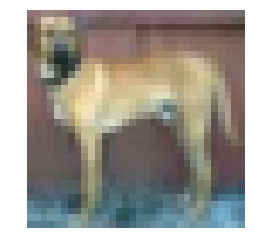

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv_net_is_training_placeholder():
    return tf.placeholder(tf.bool)

In [21]:
def conv_net(inputs, keep_prob, is_training):   
    
    # Conv Layer - 1, Input 32x32x3, Output 16x16x16
    conv1_layer = tf.layers.conv2d(inputs=inputs, filters=16, kernel_size=[3, 3], padding="SAME",
                                   activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv1_layer_mpool = tf.layers.max_pooling2d(conv1_layer, pool_size=[2, 2], strides=2)
    
    # Conv Layer - 2, Input 16x16x16, Output 8x8x32
    conv2_layer = tf.layers.conv2d(inputs=conv1_layer_mpool, filters=32, kernel_size=[3, 3], padding="SAME",
                                   activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv2_layer_mpool = tf.layers.max_pooling2d(conv2_layer, pool_size=[2, 2], strides=2)
    
    # Conv Layer - 3, Input 8x8x32, Output 4x4x32
    conv3_layer = tf.layers.conv2d(inputs=conv2_layer_mpool, filters=32, kernel_size=[3, 3], padding="SAME",
                                   activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
    conv3_layer_mpool = tf.layers.max_pooling2d(conv3_layer, pool_size=[2, 2], strides=2)
    
    # Conv Layer Flattened
    batch_size = tf.shape(conv3_layer_mpool)[0] 
    flattened_image_size = int(conv3_layer_mpool.get_shape()[1]) * \
        int(conv3_layer_mpool.get_shape()[2]) * int(conv3_layer_mpool.get_shape()[3])
    flatten = tf.reshape(conv3_layer_mpool, [batch_size, flattened_image_size])
    
    # Dense Layer - 1
    dense1_layer = tf.layers.dense(inputs=flatten, units=384, activation=tf.nn.relu)
    dense1_layer_dropout = tf.layers.dropout(inputs=dense1_layer, rate=keep_prob)
    
    # Output Layer 
    output = tf.layers.dense(inputs=dense1_layer_dropout, units=NUM_CLASSES)
    
    return output

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [22]:
tf.reset_default_graph()

- Assemble model

In [23]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()
is_training = conv_net_is_training_placeholder()

model = conv_net(inputs, keep_prob, is_training)

- Cost function, training optimizer, correct predictions, accuracy

In [24]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Batch preparation

In [25]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Hyperparameters

In [26]:
epochs = 45
batch_size = 256
keep_probability = 0.5

#### Training cycle

In [27]:
session = tf.Session()

In [28]:
session.run(tf.global_variables_initializer())

info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    batch_count = 0
    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={
            inputs: data_batch, targets: label_batch, keep_prob: keep_probability, is_training: True})

        train_cost = session.run(cost, feed_dict={
            inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})
        
        train_acc = session.run(accuracy, feed_dict={
            inputs: data_batch, targets: label_batch, keep_prob: 1., is_training: False})
        
        info["train_cost"].append(train_cost)
        info["train_acc"].append(train_acc)
        
        valid_cost = session.run(cost, feed_dict={
            inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})
        
        valid_acc = session.run(accuracy, feed_dict={
            inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1., is_training: False})
        
        info["valid_cost"].append(valid_cost)
        info["valid_acc"].append(valid_acc)
    
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_count), end='')
        print("Train error = ", "{:.5f},".format(train_cost), "Train acc = ", "{:.5f}".format(train_acc),
              "Val error = ", "{:.5f},".format(valid_cost), "Val acc = ", "{:.5f}".format(valid_acc))

Epoch  1, CIFAR-10 Batch 1:  Train error =  2.26748, Train acc =  0.15234 Val error =  2.30477, Val acc =  0.09760
Epoch  1, CIFAR-10 Batch 2:  Train error =  2.28713, Train acc =  0.10547 Val error =  2.29610, Val acc =  0.11190
Epoch  1, CIFAR-10 Batch 3:  Train error =  2.26138, Train acc =  0.16406 Val error =  2.29497, Val acc =  0.11230
Epoch  1, CIFAR-10 Batch 4:  Train error =  2.28381, Train acc =  0.10938 Val error =  2.28941, Val acc =  0.13640
Epoch  1, CIFAR-10 Batch 5:  Train error =  2.27532, Train acc =  0.14844 Val error =  2.28243, Val acc =  0.14830
Epoch  1, CIFAR-10 Batch 6:  Train error =  2.26248, Train acc =  0.18359 Val error =  2.27754, Val acc =  0.13550
Epoch  1, CIFAR-10 Batch 7:  Train error =  2.25639, Train acc =  0.12891 Val error =  2.27310, Val acc =  0.10750
Epoch  1, CIFAR-10 Batch 8:  Train error =  2.26019, Train acc =  0.12109 Val error =  2.26597, Val acc =  0.11240
Epoch  1, CIFAR-10 Batch 9:  Train error =  2.23825, Train acc =  0.20703 Val er

Epoch  1, CIFAR-10 Batch 72:  Train error =  1.61488, Train acc =  0.42578 Val error =  1.68314, Val acc =  0.39520
Epoch  1, CIFAR-10 Batch 73:  Train error =  1.73728, Train acc =  0.35938 Val error =  1.68937, Val acc =  0.39280
Epoch  1, CIFAR-10 Batch 74:  Train error =  1.65138, Train acc =  0.41797 Val error =  1.69253, Val acc =  0.39220
Epoch  1, CIFAR-10 Batch 75:  Train error =  1.68069, Train acc =  0.41016 Val error =  1.68159, Val acc =  0.39200
Epoch  1, CIFAR-10 Batch 76:  Train error =  1.70869, Train acc =  0.41406 Val error =  1.69186, Val acc =  0.38690
Epoch  1, CIFAR-10 Batch 77:  Train error =  1.67424, Train acc =  0.43750 Val error =  1.65904, Val acc =  0.40340
Epoch  1, CIFAR-10 Batch 78:  Train error =  1.60028, Train acc =  0.44531 Val error =  1.65302, Val acc =  0.40980
Epoch  1, CIFAR-10 Batch 79:  Train error =  1.68970, Train acc =  0.39453 Val error =  1.65284, Val acc =  0.40680
Epoch  1, CIFAR-10 Batch 80:  Train error =  1.62085, Train acc =  0.359

Epoch  1, CIFAR-10 Batch 143:  Train error =  1.55708, Train acc =  0.42969 Val error =  1.47267, Val acc =  0.46600
Epoch  1, CIFAR-10 Batch 144:  Train error =  1.46063, Train acc =  0.46484 Val error =  1.50237, Val acc =  0.46240
Epoch  1, CIFAR-10 Batch 145:  Train error =  1.45939, Train acc =  0.50391 Val error =  1.45878, Val acc =  0.47740
Epoch  1, CIFAR-10 Batch 146:  Train error =  1.49412, Train acc =  0.45703 Val error =  1.47860, Val acc =  0.47180
Epoch  1, CIFAR-10 Batch 147:  Train error =  1.40262, Train acc =  0.47656 Val error =  1.46947, Val acc =  0.47260
Epoch  1, CIFAR-10 Batch 148:  Train error =  1.51755, Train acc =  0.45703 Val error =  1.45973, Val acc =  0.47100
Epoch  1, CIFAR-10 Batch 149:  Train error =  1.50260, Train acc =  0.46875 Val error =  1.45522, Val acc =  0.47080
Epoch  1, CIFAR-10 Batch 150:  Train error =  1.40110, Train acc =  0.50000 Val error =  1.46589, Val acc =  0.47530
Epoch  1, CIFAR-10 Batch 151:  Train error =  1.49932, Train acc

KeyboardInterrupt: 

#### Results

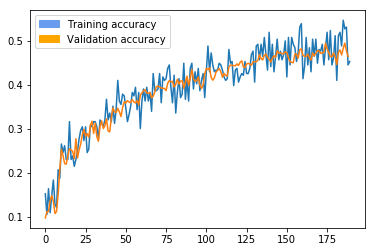

In [29]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

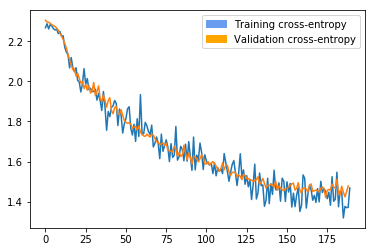

In [30]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [33]:
test_acc = session.run(accuracy, feed_dict={
    inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1.})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.4704


In [ ]:
session.close()